<a href="https://colab.research.google.com/github/anuarsantoyo/master-thesis/blob/master/evaluation_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

In [5]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 20, 'lines.linewidth': 3, 'lines.markersize': 15, 'figure.figsize': (11.7, 8.27)}) #
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True

# Import Data

In [ ]:
#%cd ..

In [6]:
df, cluster_input_cols, answers_train, answers, labels, _ = get_cluster_data(n_cluster=2, method='kmeans', cov_type='full', cluster_input_data='fa_data', start_train='2020-08-01', end_train='2020-12-01', start='2020-07-21')

In [ ]:
df.shape

(50139, 86)

In [ ]:
answers_train.shape

(33165, 5)

In [ ]:
answers.shape

(50139, 5)

In [ ]:
labels.shape

(50139,)

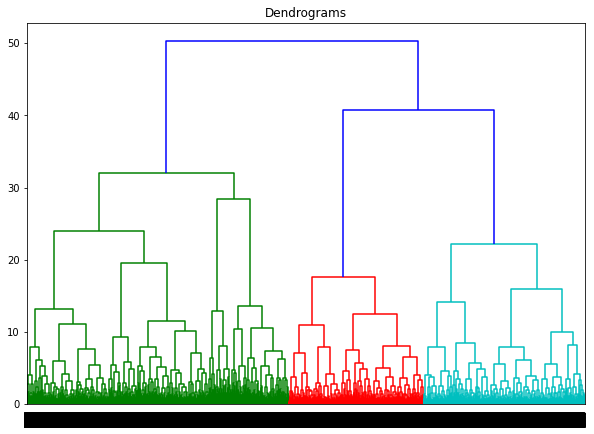

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(answers_train, method='ward'))

# Metrics

In [ ]:
ch_score = metrics.calinski_harabasz_score(answers, labels)
silhouette_score = metrics.silhouette_score(answers, labels, metric='euclidean')
db_score = metrics.davies_bouldin_score(answers, labels)
print('Calinski Harabasz Score: ' + str(ch_score))
print('Silhouette Score: ' + str(silhouette_score))
print('Davies Bouldin Score: ' + str(db_score))

Calinski Harabasz Score: 13953.907070459943
Silhouette Score: 0.22779856999311673
Davies Bouldin Score: 1.6865490544009576


# Plot Group Size

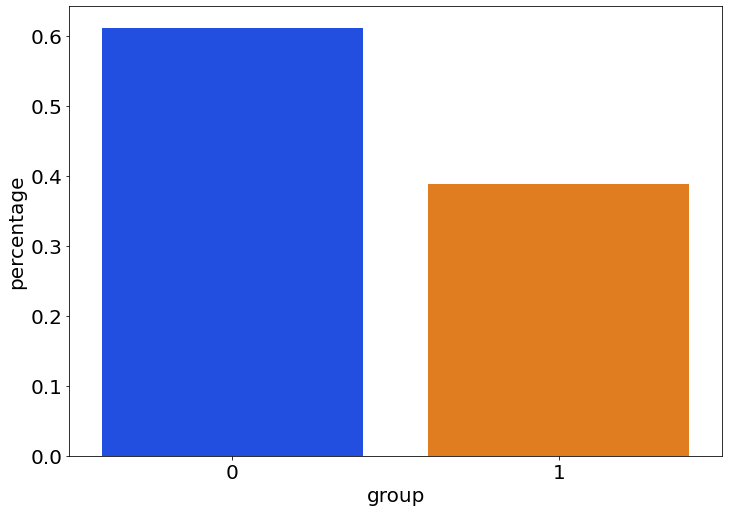

In [7]:
df_group_size = df[['group', 'gender']].groupby('group').count().reset_index()
df_group_size['gender'] = df_group_size['gender'] / df_group_size['gender'].sum()
df_group_size.rename(columns={'gender':'percentage'}, inplace=True)
sns.barplot(data=df_group_size, x='group', y='percentage', palette='bright')

# Heatmap - Comparison: group dependend average factor values to overall average factor values

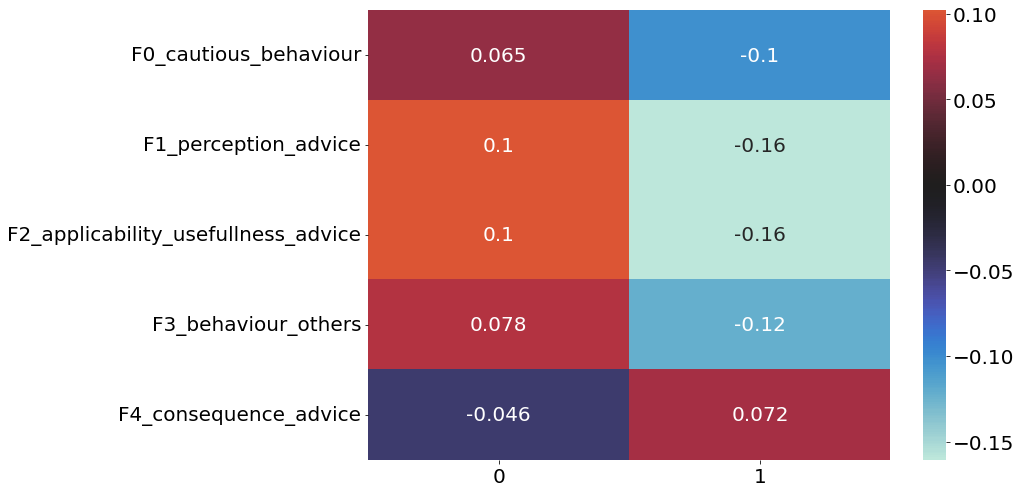

In [8]:
df_heatmap = pd.DataFrame(data=answers, columns=cluster_input_cols)
df_heatmap['group'] = labels
df_heatmap = df_heatmap.groupby('group').mean().reset_index(drop=True).transpose()
for col in df_heatmap.columns:
  df_heatmap[col] = df_heatmap[col] - answers.mean(axis=0)
sns.heatmap(df_heatmap, center=0, robust=True, annot=True)

# Daily Distribution

In [14]:
from model.modelhelper import *
start_time='2020-08-01'
end_time='2021-02-01'
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=7)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.428571,61.142857,3.571429
1,2020-08-02,0.428571,69.000000,3.571429
2,2020-08-03,0.428571,76.714286,4.142857


In [11]:
df_perc = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = df_perc[df_perc['date']==row['date']]['gender'].sum()
  return row['gender']/sum
df_perc['percentage'] = df_perc.apply(lambda x: normalize(x), axis=1)
df_perc.drop(columns='gender',inplace=True)
df_perc_roll_avg = pd.DataFrame()
for group in np.arange(len(df_perc['group'].unique())):
  df_temp = df_perc[df_perc['group']==group].groupby('date').mean().rolling(7).mean().reset_index()
  df_perc_roll_avg = pd.concat([df_perc_roll_avg, df_temp])
df_perc_roll_avg.dropna(inplace=True)
df_perc_roll_avg.reset_index(inplace=True, drop=True)

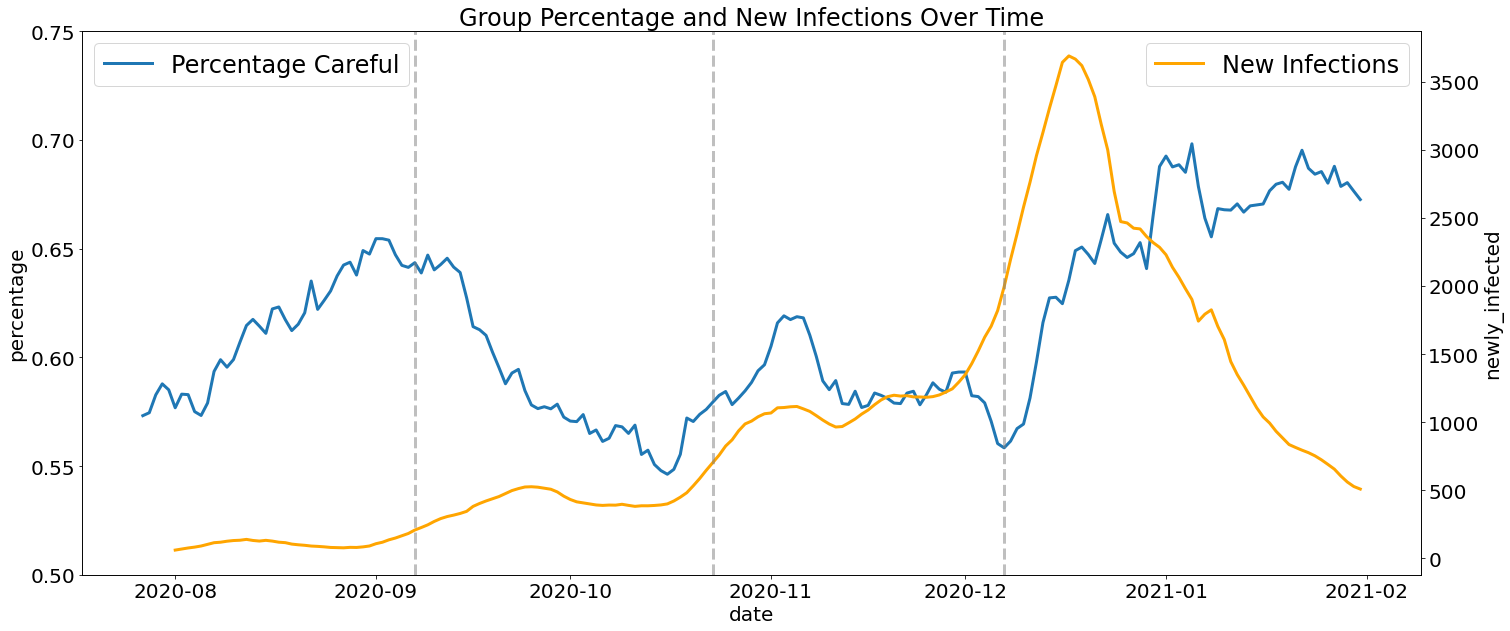

In [38]:
dt_format = '%Y-%m-%d'
fig, ax = plt.subplots(figsize=(24, 10))
plt.title('Group Percentage and New Infections Over Time')
sns.lineplot(x="date", y="percentage", data=df_perc_roll_avg[df_perc_roll_avg['group']==0], ax=ax, label='Percentage Careful')
ax.set(ylim=(0.5, 0.75))
ax2 = plt.twinx()
sns.lineplot(data=df_obs, x='Date', y='newly_infected', ax=ax2, color='orange', label='New Infections')
plt.axvline(x=pd.to_datetime('2020-09-07', format=dt_format), linestyle='--', color='grey', alpha=0.5)
plt.axvline(x=pd.to_datetime('2020-10-23', format=dt_format), linestyle='--', color='grey', alpha=0.5)
plt.axvline(x=pd.to_datetime('2020-12-07', format=dt_format), linestyle='--', color='grey', alpha=0.5)
ax.legend(loc='upper left', fontsize='large')
ax2.legend(loc='upper right', fontsize='large')
fig.savefig("images/group_percentage_lineplot.png")
plt.show()

No handles with labels found to put in legend.


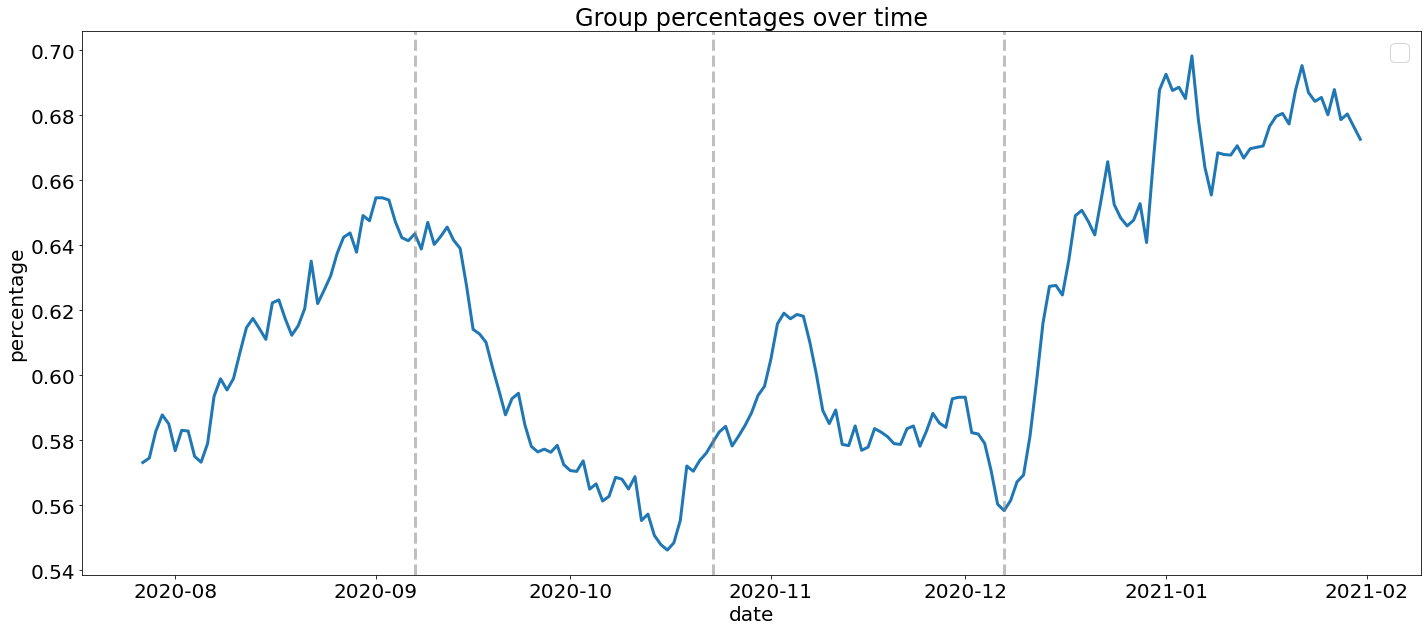

In [16]:
dt_format = '%Y-%m-%d'
fig, ax = plt.subplots(figsize=(24, 10))
sns.lineplot(x="date", y="percentage", hue='group', data=df_perc_roll_avg, ax=ax)
plt.title('Group percentages over time')
ax.legend(loc='best', fontsize='large')
plt.axvline(x=pd.to_datetime('2020-09-07', format=dt_format), linestyle='--', color='grey', alpha=0.5)
plt.axvline(x=pd.to_datetime('2020-10-23', format=dt_format), linestyle='--', color='grey', alpha=0.5)
plt.axvline(x=pd.to_datetime('2020-12-07', format=dt_format), linestyle='--', color='grey', alpha=0.5)
#fig.savefig("images/group_percentage_lineplot.png")
plt.show()

In [ ]:
£df_model_input = df_perc.pivot(index='date', columns='group', values='percentage').reset_index()
df_model_input.drop(columns=[0.0], inplace=True)
#df_model_input.to_csv('data/modeling/group_percentage_non_careful.csv', index=False)
df_model_input.head()

group,date,1
0,2020-07-21,0.386667
1,2020-07-22,0.467128
2,2020-07-23,0.451064
3,2020-07-24,0.462151
4,2020-07-25,0.379939


# Pairgrid Factors

In [ ]:
start = '2020-08-01'
end = '2021-02-01'
in_range = (df.date > start) & (df.date < end)
df_timewindow = df[in_range]

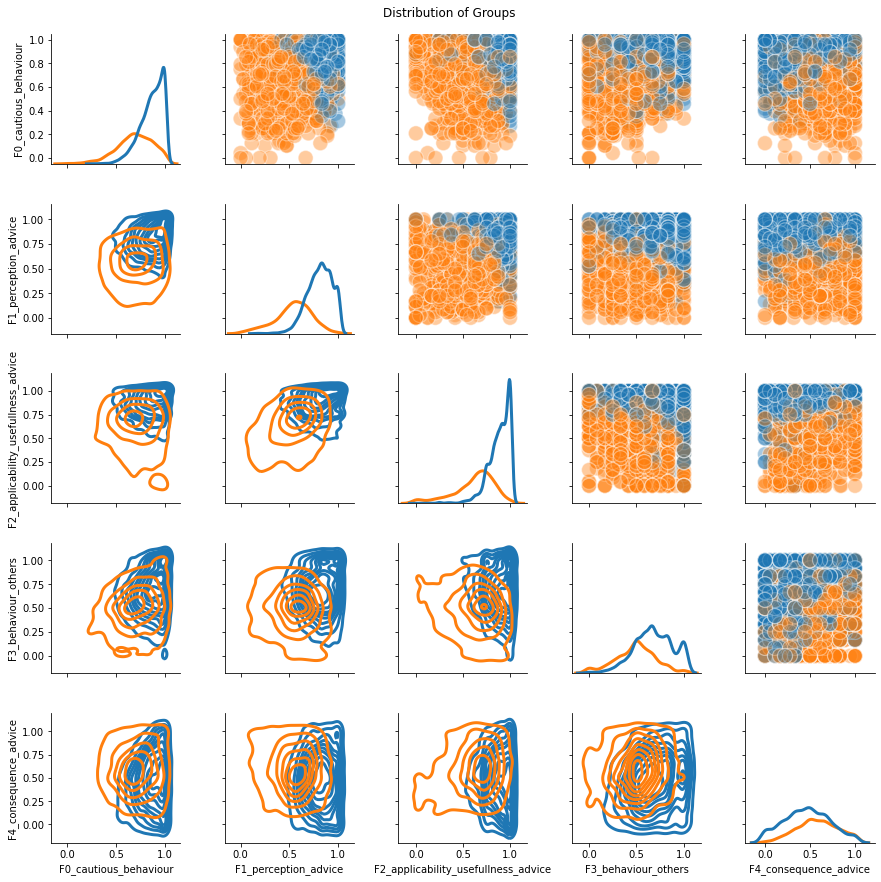

In [ ]:
g = sns.PairGrid(data=df_timewindow.sample(5000), vars=cluster_input_cols, hue='group')
g.map_upper(sns.scatterplot, alpha=0.4)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Distribution of Groups')
g.fig.savefig("images/distribution_groups.png")
plt.show()

# 3D Scatterplot

In [ ]:
df_timewindow.group = df_timewindow.group.astype(str)
fig = px.scatter_3d(df_timewindow, x=cluster_input_cols[0], y=cluster_input_cols[1], z=cluster_input_cols[2], color='group', opacity=0.95)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=5, range=[0, 1],),
                     yaxis = dict(nticks=5, range=[0, 1],),
                     zaxis = dict(nticks=5, range=[0, 1],),),
        width=1600, height=700, margin=dict(r=20, l=10, b=10, t=10))
fig.show()

# Daily Average Group Answer

In [ ]:
df_roll_daily_avg = pd.DataFrame()
for group in np.arange(len(df_perc['group'].unique())):
  df_temp = df[df['group']==group].groupby('date').mean().rolling(7).mean().reset_index()
  df_roll_daily_avg = pd.concat([df_roll_daily_avg, df_temp])
df_roll_daily_avg.reset_index(inplace=True, drop=True)

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average.date = pd.to_datetime(df_daily_average.date)
for col in cluster_input_cols:
    sns.lineplot(data=df_roll_daily_avg, x='date', y=col, hue='group', palette="bright")
    sns.lineplot(data=df_roll_daily_avg, x='date', y=col)
    plt.title(col)
    plt.show()

# Group Distance

In [ ]:
df_dict = []
for i, day in  df[factor_cols + ['date', 'group']].groupby(['date']):
     groups_dist = np.abs(day[day['group']== 0].mean() - day[day['group']== 1].mean())
     dist = np.linalg.norm(groups_dist.values, ord=1)
     df_dict.append({'date':i, 'distance': dist})
df_dist = pd.DataFrame(df_dict)
df_dist['dist_smooth'] = df_dist.distance.rolling(7).mean()
fig = px.line(df_dist,x='date', y=['distance', 'dist_smooth'])
fig.show()

# Comparison R-Value and Group Percentage

In [ ]:
df_rvalue = pd.read_csv('data/infered_rvalue.csv')
df_rvalue.date = pd.to_datetime(df_rvalue.date, format='%Y-%m-%d')
df_rvalue.head()

In [ ]:
group_to_plot= 0

fig, ax1 = plt.subplots(figsize=(20, 8))
df_plot = df_perc_save#df_perc_roll_avg[df_perc_roll_avg['group'] == group_to_plot]
df_plot['percentage_transformed'] = np.exp(df_plot['percentage'])
color = 'tab:red'
ax1.set_xlabel('date')
ax1_ylabel = 'Group ' + str(group_to_plot) + ' Percentage'
ax1.set_ylabel(ax1_ylabel, color=color)
ax1.plot(df_plot['date'], df_plot['percentage'], color=color)
#ax1.plot(df_plot['date'], df_plot['percentage_transformed'], color='grey')
#ax1.plot(df_dist['date'], df_dist['dist_smooth'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R Value', color=color)  # we already handled the x-label with ax1
ax2.plot(df_rvalue['date'], df_rvalue['R_t'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Granger Test - Observations

In [ ]:
df_observations = pd.read_csv('data/observations_30012022.csv',sep=';', decimal=',', encoding='utf-8', index_col='Unnamed: 0')
df_observations.Date = pd.to_datetime(df_observations.Date, format='%Y-%m-%d')
start = '2020-08-01'
end = '2021-02-01'
in_range = (df_observations.Date > start) & (df_observations.Date < end)
df_observations = df_observations[in_range]
fig = px.line(df_observations, x="Date", y=['Confirmed_cases', 'Admissions_hospital'], title='Observations')
fig.show()

In [ ]:
df_granger_test = pd.merge(df_plot, observations[['Date', 'Admissions_hospital']], left_on='date', right_on='Date').drop(columns=['Date', 'group'])
df_granger_test.head()

In [ ]:
!pip install statsmodels --upgrade
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_granger_test['percentage'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

In [ ]:
result = adfuller(df_granger_test['Admissions_hospital'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

In [ ]:
df_transformed = df_granger_test.copy()
df_transformed[['percentage', 'Admissions_hospital']] = df_granger_test[['percentage', 'Admissions_hospital']].diff()#.dropna()
df_transformed.dropna(inplace=True)
df_transformed.head()

In [ ]:
plt.plot(df_transformed.date, df_transformed.percentage)
plt.show()
plt.plot(df_transformed.date, df_transformed.Admissions_hospital)
plt.show()

In [ ]:
result = adfuller(df_transformed['percentage'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

In [ ]:
result = adfuller(df_transformed['Admissions_hospital'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

In [ ]:
for i in np.arange(2,20):
  dict_granger = grangercausalitytests(df_transformed[['percentage', 'Admissions_hospital']], maxlag=[i])
  print(dict_granger[i][0]['params_ftest'][1])

# GIF Creation

In [ ]:
"""df_timeframe = df.copy()
df_timeframe['date'] = pd.to_datetime(df_timeframe['date'])

plt.ioff()
for nr_weeks in range(52):
  dt_start_temp = df_timeframe.date.min() + timedelta(days=7) * nr_weeks
  dt_end_temp = dt_start_temp + timedelta(days=14)
  time_window = (df_timeframe['date'] > dt_start_temp) & (df_timeframe['date'] < dt_end_temp)
  df_timeframe_temp = df_timeframe[time_window]


  g = sns.JointGrid(data=df_timeframe_temp, x=top_cols[1], y=top_cols[2], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
  g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot
  g.plot_marginals(sns.histplot, kde=True) #or kdeplot
  fig = g.fig
  fig.suptitle(dt_start_temp.strftime("%Y-%m-%d") + ' - ' + dt_end_temp.strftime("%Y-%m-%d"))
  fig.savefig("gif_creation/images/out_"+dt_start_temp.strftime("%Y_%m_%d") + ".png")
  plt.close(fig)"""

In [ ]:
"""# Create GIF
images = []
path = 'gif_creation/images/'

for filename in os.listdir(path):
  images.append(imageio.imread(path+filename))
  os.remove(path+filename)
imageio.mimsave('gif_creation/gmm_grouped.gif', images, duration=0.5)"""